# House Prices - Competition

The object of the competition is to predict the house prices as precisely as possible using database that contains 79 explanatory variables of the residental homes in Ames, Iowa.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Importing needed libraries and data

In [1]:
# Importing needed tools
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


# Getting the data to train the models
home_filepath = '../input/house-prices-advanced-regression-techniques/train.csv'
full_home_data = pd.read_csv(home_filepath, index_col='Id')

# Getting the data for which we give predictions
test_data_path = '../input/house-prices-advanced-regression-techniques/test.csv'
full_test_data = pd.read_csv(test_data_path, index_col='Id')

## Initial data analysis

In [2]:
full_home_data.info()
print('************')
full_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

I will separete first the categorical and numerical features.

In [3]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in full_home_data.columns if
                    full_home_data[cname].nunique() < 10 and 
                    full_home_data[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in full_home_data.columns if 
                full_home_data[cname].dtype in ['int64', 'float64']]

## Choosing features to use

Right now I only use first the numeric features. Later I will taek also categorical features in play.

In [4]:
numeric_corr = full_home_data[numerical_cols].corr()
sale_price_corr_table = numeric_corr['SalePrice'].sort_values(ascending=False).to_frame()
sale_price_corr_table

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Let's choose the ones that correlation with the price is more than 0.25.

In [5]:
num_features = sale_price_corr_table[(sale_price_corr_table['SalePrice']>0.25) & (sale_price_corr_table['SalePrice']<1)].index.to_list()
full_home_data[num_features].describe()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1452.000000,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,472.980137,1057.429452,1162.626712,1.565068,6.517808,1971.267808,1984.865753,1978.506164,103.685262,0.613014,443.639726,70.049958,94.244521,346.992466,46.660274,0.382877,10516.828082
std,1.382997,525.480383,0.747315,213.804841,438.705324,386.587738,0.550916,1.625393,30.202904,20.645407,24.689725,181.066207,0.644666,456.098091,24.284752,125.338794,436.528436,66.256028,0.502885,9981.264932
min,1.000000,334.000000,0.000000,0.000000,0.000000,334.000000,0.000000,2.000000,1872.000000,1950.000000,1900.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,1300.000000
25%,5.000000,1129.500000,1.000000,334.500000,795.750000,882.000000,1.000000,5.000000,1954.000000,1967.000000,1961.000000,0.000000,0.000000,0.000000,59.000000,0.000000,0.000000,0.000000,0.000000,7553.500000
50%,6.000000,1464.000000,2.000000,480.000000,991.500000,1087.000000,2.000000,6.000000,1973.000000,1994.000000,1980.000000,0.000000,1.000000,383.500000,69.000000,0.000000,0.000000,25.000000,0.000000,9478.500000
75%,7.000000,1776.750000,2.000000,576.000000,1298.250000,1391.250000,2.000000,7.000000,2000.000000,2004.000000,2002.000000,166.000000,1.000000,712.250000,80.000000,168.000000,728.000000,68.000000,1.000000,11601.500000
max,10.000000,5642.000000,4.000000,1418.000000,6110.000000,4692.000000,3.000000,14.000000,2010.000000,2010.000000,2010.000000,1600.000000,3.000000,5644.000000,313.000000,857.000000,2065.000000,547.000000,2.000000,215245.000000


Let's see how these correlate with each other. If there are terms that correlate with each other a lot, it is not necessary to include them to the features.

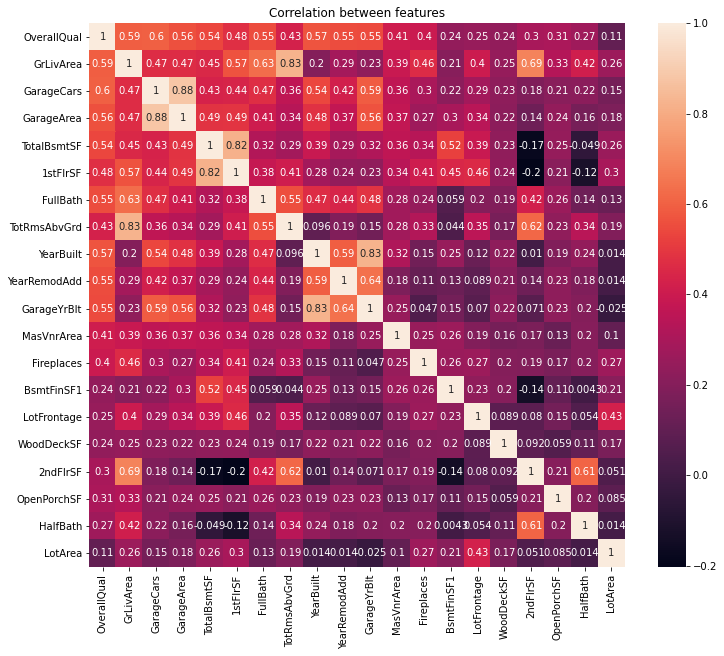

In [6]:
plt.figure(figsize=(12,10))
plt.title('Correlation between features')
sns.heatmap(full_home_data[num_features].corr(), annot=True)

So there is a high correlation between GarareCars and GarageArea, TotalBsmtSF and 1stFlrSF, GrLivArea and TotRmsAbvGrd, YearBlt and GarareYrBlt. Therefore I will remove the features: GarageArea, TotalBsmtSF, TotRmsAbvGrd and GarageYrBlt.

In [7]:
num_features.remove('GarageArea')
num_features.remove('TotalBsmtSF')
num_features.remove('TotRmsAbvGrd')
num_features.remove('GarageYrBlt')
# this probably could be done with some kind of code, but this was so few of them so I did it by hand.

In [8]:
full_home_data[num_features].describe()

,OverallQual,GrLivArea,GarageCars,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,1162.626712,1.565068,1971.267808,1984.865753,103.685262,0.613014,443.639726,70.049958,94.244521,346.992466,46.660274,0.382877,10516.828082
std,1.382997,525.480383,0.747315,386.587738,0.550916,30.202904,20.645407,181.066207,0.644666,456.098091,24.284752,125.338794,436.528436,66.256028,0.502885,9981.264932
min,1.000000,334.000000,0.000000,334.000000,0.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,1300.000000
25%,5.000000,1129.500000,1.000000,882.000000,1.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,59.000000,0.000000,0.000000,0.000000,0.000000,7553.500000
50%,6.000000,1464.000000,2.000000,1087.000000,2.000000,1973.000000,1994.000000,0.000000,1.000000,383.500000,69.000000,0.000000,0.000000,25.000000,0.000000,9478.500000
75%,7.000000,1776.750000,2.000000,1391.250000,2.000000,2000.000000,2004.000000,166.000000,1.000000,712.250000,80.000000,168.000000,728.000000,68.000000,1.000000,11601.500000
max,10.000000,5642.000000,4.000000,4692.000000,3.000000,2010.000000,2010.000000,1600.000000,3.000000,5644.000000,313.000000,857.000000,2065.000000,547.000000,2.000000,215245.000000


## Dividing the data to test set and the train set

In [9]:
# Select target
y = full_home_data.SalePrice

# Select X
X = full_home_data[num_features].copy()
X_test = full_test_data[num_features].copy()

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

## Replacing missing values and making model
First we try very simple method for replacing missing values and see how it goes. Later we figure out more sophisticated methods for replacing missing values.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean') # MAE 18089.78
# numerical_transformer = SimpleImputer(strategy='median') # MAE 18120.04



# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)


# Bundle preprocessing and modeling code in a pipeline
regressor = Pipeline(steps=[('preprocessor', numerical_transformer),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
regressor.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = regressor.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 18089.778646444876


### Other possible model

In [21]:
from xgboost import XGBRegressor

# Define the model
my_model_1 = XGBRegressor(n_estimators= 1000, learning_rate=0.05, random_state=0)

# Fit the model
my_model_1.fit(X_train, y_train)

preds2 = my_model_1.predict(X_valid)
print('MAE:', mean_absolute_error(y_valid, preds2))

MAE: 17494.610231164384


## Making final predictions of test data

In [22]:
final_regressor = XGBRegressor(n_estimators= 1000, learning_rate=0.05, random_state=0)
final_regressor.fit(X,y)
preds_test = final_regressor.predict(X_test)

In [23]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

Altought it here seems that the XGBRegressor gives a better model, the test results the RandomForestRegressor predicted better when I submitted them.